# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [4]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re # Regular expression operations
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [5]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [485]:
### STUDENT START ###

def P1(num_examples=5):
    for i in range(0,num_examples):
        print("Text %d: \n\n" %(i+1))
        print("The label code is %d" %train_labels[i])
        print("The label is: ", categories[train_labels[i]], "\n")
        print("The content is: \n\n", train_data[i], "\n\n")
        
### STUDENT END ###
P1()

Text 1: 


The label code is 1
The label is:  talk.religion.misc 

The content is: 

 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 


Text 2: 


The label code is 3
The label is:  sci.space 

The content is: 

 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones,

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [8]:
def P2():
### STUDENT START ###

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)

    # a. 
    print("A)\n\nThe size of the vocabulary is %d " % X.shape[1])
    print("The average number of non-zero features per example is %.2f" % (X.nnz/X.shape[0]))
    print("The fraction of the entries in the matrix that are non-zero %.4f" 
          % (X.nnz/(X.shape[0]*X.shape[1])))

    # b.
    features = sorted(vectorizer.get_feature_names())
    print("B)\n\nThe 0th feature string is ", features[0])
    print("The last feature string is ", features[-1])

    # c.
    my_vocabs = ["atheism", "graphics", "space", "religion"]

    vectorizer2c = CountVectorizer()
    vectorizer2c.vocabulary = my_vocabs
    X2c = vectorizer2c.fit_transform(train_data)


    print("\n\nC) With my own vocabulary set: \n")
    print("The size of the vocabulary is %d " % X2c.shape[1])
    print("The size of the training data is %d " % X2c.shape[0])
    print("The average number of non-zero features per example is %.2f" % (X2c.nnz/X2c.shape[0]))

    # d.

    print("\n\nD) Bigram and Trigram characters extraction: \n")
    vectorizer2d = CountVectorizer(ngram_range=(2,3), analyzer="char")
    X2d = vectorizer2d.fit_transform(train_data)
    print("The size of the vocabulary for bigram and trigram characters is %d " % X2d.shape[1])

    # e.
    vectorizer2e = CountVectorizer(min_df=10)
    X2e = vectorizer2e.fit_transform(train_data)
    print("\n\nE) When min_df is 10, the size of the vocabulary is %d " % X2e.shape[1])

    # f.

    vectorizer_dev = CountVectorizer(min_df=1)
    X_dev = vectorizer_dev.fit_transform(dev_data)
    print("\nF) The fraction of the words in the dev data that are missing from the vocabulary is %.3f" % (1-(X_dev.shape[1]/X.shape[1])))

### STUDENT END ###
P2()

A)

The size of the vocabulary is 26879 
The average number of non-zero features per example is 96.71
The fraction of the entries in the matrix that are non-zero 0.0036
B)

The 0th feature string is  00
The last feature string is  zyxel


C) With my own vocabulary set: 

The size of the vocabulary is 4 
The size of the training data is 2034 
The average number of non-zero features per example is 0.27


D) Bigram and Trigram characters extraction: 

The size of the vocabulary for bigram and trigram characters is 35478 


E) When min_df is 10, the size of the vocabulary is 3064 

F) The fraction of the words in the dev data that are missing from the vocabulary is 0.396


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [489]:
def P3():
### STUDENT START ###

    pipeline_KNN = Pipeline([  
        ('vectorizer', CountVectorizer()),
        ('classifier', KNeighborsClassifier()),
        ])

    pipeline_MNB = Pipeline([  
        ('vectorizer', CountVectorizer()),
        ('classifier', MultinomialNB())
        ])

    pipeline_LLM = Pipeline([  
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression(penalty='l2'))
        ])


    KNN_parameters = {
        'classifier__n_neighbors': (1, 3, 5, 7, 9)
    }


    MNB_parameters = {
        'classifier__alpha': (0.01, 0.1, 0.5, 0.9, 0.95, 0.99)
    }


    LLM_parameters = {
        'classifier__C': (0.01, 0.1, 0.5, 0.9, 0.95, 0.99)
    }


    grid_search_KNN = GridSearchCV(pipeline_KNN, KNN_parameters)
    grid_search_MNB = GridSearchCV(pipeline_MNB, MNB_parameters)
    grid_search_LLM = GridSearchCV(pipeline_LLM, LLM_parameters)

    grid_search_KNN.fit(train_data, train_labels)
    grid_search_MNB.fit(train_data, train_labels)
    grid_search_LLM.fit(train_data, train_labels)

    print("The best score for KNeighborsClassifier is %.3f." % grid_search_KNN.best_score_)
    print("The best score for MultinomialNB is %.3f." % grid_search_MNB.best_score_)
    print("The best score for LogisticRegression is %.3f." % grid_search_LLM.best_score_)

    best_params_KNN = grid_search_KNN.best_estimator_.get_params()
    best_params_MNB = grid_search_MNB.best_estimator_.get_params()
    best_params_LLM = grid_search_LLM.best_estimator_.get_params()

    pipeline_KNN.fit(train_data, train_labels)
    pipeline_MNB.fit(train_data, train_labels)
    pipeline_LLM.fit(train_data, train_labels)

    print("\nThe best N parameter for KNeighborsClassifier is ", best_params_KNN['classifier__n_neighbors'])
    print("The best Alpha parameter for MultinomialNB is ", best_params_MNB['classifier__alpha'])
    print("The best C parameter for LogisticRegression ", best_params_LLM['classifier__C'])

    pipeline_KNN.set_params(classifier__n_neighbors=best_params_KNN['classifier__n_neighbors']).fit(train_data, train_labels)
    pipeline_MNB.set_params(classifier__alpha=best_params_MNB['classifier__alpha']).fit(train_data, train_labels)
    pipeline_LLM.set_params(classifier__C=best_params_LLM['classifier__C']).fit(train_data, train_labels)


    metric_KNN = metrics.f1_score(dev_labels, pipeline_KNN.predict(dev_data), average=None)
    metric_MNB = metrics.f1_score(dev_labels, pipeline_MNB.predict(dev_data), average=None)
    metric_LLM = metrics.f1_score(dev_labels, pipeline_LLM.predict(dev_data), average=None)

    print("\nF1 Scores for each 4 categories:\n")
    print(" ''".join(map(str, newsgroups_train.target_names)))
    print("KNN: ", metric_KNN)
    print("MNB: ", metric_MNB)
    print("LLM: ", metric_LLM)

### STUDENT END ###
P3()

The best score for KNeighborsClassifier is 0.411.
The best score for MultinomialNB is 0.829.
The best score for LogisticRegression is 0.771.

The best N parameter for KNeighborsClassifier is  9
The best Alpha parameter for MultinomialNB is  0.01
The best C parameter for LogisticRegression  0.5

F1 Scores for each 4 categories:

alt.atheism ''comp.graphics ''sci.space ''talk.religion.misc
KNN:  [0.43126685 0.46583851 0.50938338 0.28671329]
MNB:  [0.69005848 0.91256831 0.849642   0.56888889]
LLM:  [0.58785942 0.8372093  0.78554217 0.56540084]


a. Why doesn't nearest neighbors work well for this problem?

ANSWER: The text content is very sparse with over 26 thousands features in each example, in which most features are 0, making it very difficult for the K-Nearest Neighbor algorithm to identify the correct label. 


b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

ANSWER: According to this study (http://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf), logistic regression performs better than Naive Bayes model, when the training size is infinite. However, in this training example that we have, the training size (2,304) is relatively small compared to the number of features (26,879), which in general helps improve the results for Naive Bayes (ref: http://dataespresso.com/en/2017/10/24/comparison-between-naive-bayes-and-logistic-regression/). For logistic regression, when we have a small training size like this, the regularization parameter like Lasso (L1) or Ridge (L2) can help adjust the fitting and results of the model; increasing it makes the model more parsimonious (more generalized).

Reference:
(i) https://medium.com/@sangha_deb/naive-bayes-vs-logistic-regression-a319b07a5d4c
(ii) http://dataespresso.com/en/2017/10/24/comparison-between-naive-bayes-and-logistic-regression/

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. 

In [204]:
c_params = (0.01, 0.1, 0.5, 0.9, 0.95, 0.99)

# vectorize the train data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_data)

for i in c_params:
    clf = LogisticRegression(C=i, penalty='l2')
    clf.fit(X, train_labels)
    print("Given C of %.2f, the sums of quared weights are " %i, np.sum(np.square(clf.coef_), axis=1))

Given C of 0.01, the sums of quared weights are  [2.54147847 2.93970937 2.86246884 2.25002921]
Given C of 0.10, the sums of quared weights are  [27.12949733 24.65904426 27.45774154 23.02605311]
Given C of 0.50, the sums of quared weights are  [102.59430054  83.11964857  99.0380729   89.00735647]
Given C of 0.90, the sums of quared weights are  [155.60567409 122.48404975 147.62579852 135.68786572]
Given C of 0.95, the sums of quared weights are  [161.36248566 126.76976864 152.86480614 140.75764014]
Given C of 0.99, the sums of quared weights are  [165.93557871 130.06071723 156.94549779 144.75894096]


ANSWER:

c. Briefly explain the relationship between the sum and the value of C.

ANSWER: The higher value of C leads to the higher sum. The C parameter reduces the regularization of the model. This means that the higher the C the fitter the model to the training data set, and therefore the higher coefficiencts in general, as reflected in the results above.

Reference: https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [490]:
import pandas as pd

def P4(ngram_range=(1,1), analyzer="word"):
### STUDENT START ###

# vectorize the train data
    vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer=analyzer)
    X = vectorizer.fit_transform(train_data)

    clf = LogisticRegression(C=0.5, penalty='l2')
    clf.fit(X, train_labels)
    
    feature_names = np.array(vectorizer.get_feature_names())
    
    # identify list of features
    list_20 = []    
    summary = []
    
    for i in clf.classes_:
        coef_arr = clf.coef_[i]
        sorted_arr = np.argsort(coef_arr)[::-1]
        top_5 = sorted_arr[:5]
        list_20 = np.append(list_20, top_5)
    
    # convert to integer index
    list_20 = np.intp(list_20)
    
    
    for i in clf.classes_:
        coef_arr = clf.coef_[i]
        summary.append(coef_arr[list_20])

    
    tabular = pd.DataFrame(data=summary, index = newsgroups_train.target_names, columns=feature_names[list_20])
    print(tabular.transpose())


### STUDENT END ###

print("Top 5 features for each label: ")

P4((1,1),"word")

print("\n\nNow with bigrams: ")

P4((2,2),"word")

Top 5 features for each label: 
            alt.atheism  comp.graphics  sci.space  talk.religion.misc
atheists       0.833768      -0.093275  -0.267485           -0.637641
bobby          0.823506      -0.191203  -0.286428           -0.387213
religion       0.798448      -0.508669  -0.658864           -0.050622
atheism        0.794564      -0.348535  -0.367224           -0.377050
deletion       0.724231      -0.249529  -0.272483           -0.270472
graphics      -0.640828       1.626449  -1.103015           -0.626312
image         -0.469386       1.116823  -0.672285           -0.381285
file          -0.275279       1.058950  -0.682659           -0.506144
3d            -0.303503       0.941460  -0.571106           -0.317598
computer       0.071194       0.843823  -0.569510           -0.396111
space         -1.061440      -1.115717   1.864149           -0.972114
orbit         -0.350352      -0.559732   1.012751           -0.498991
nasa          -0.465449      -0.410371   0.851692         

ANSWER: In the single word features, all features are unique across 5 labels. In the bigram features, some features tend to have high coefficients in the labels that are in similar topics. For examples, "cheers kent" appears as one in top 5 under both "atheism" and "religion" topics. In another example, "you are" feature is in one of the top 5 for "atheism" and also has a positive coefficient for "religion" topic as well.

Another observation for the bigram features is that there are a lot of "Verb to Be" such as "was just", "you are", "are you", "is there", "it was, and "ignorance is". This makes sense considering that "verb to be" is the most important verb in English.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [295]:
def p5_training(train=train_data, labels=train_labels, text="no processor", dataset = "training"):

    pipeline_LLM_p5 = Pipeline([  
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression(C=0.5, penalty='l2'))
        ])

    pipeline_LLM_p5.fit(train, labels)
    
    vectorizer5 = CountVectorizer()
    X5 = vectorizer5.fit_transform(train, labels)

    metric_LLM_p5 = metrics.f1_score(dev_labels, pipeline_LLM_p5.predict(dev_data), average='macro')

#    print("Dataset (%s): " % dataset, " ''".join(map(str, categories)))
    print("F1 (%s): " %text, metric_LLM_p5)
    print("The size of the dictionary is: %d " % X5.shape[1],"\n\n")

In [296]:
def better_preprocessor(s):
### STUDENT START ###
    
    #lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words
    old = ''
    new = s.lower()
    while new != old:
        old = new
        old = re.sub(r'\s+', ' ', old) 
        old = re.sub(r'ies\b', 'y', old)
        old = re.sub(r'the\b', '', old)
        old = re.sub(r'_+', '', old)
        old = re.sub(r'\bre-\b', 're', old)
        old = re.sub('[0-9]*(\,?[0-9]*)*\.?[0-9]+', '<NUM>', old)
        old = re.sub('([\#\.\-]?\<NUM\>)+', '<NUM>', old)
        new = old.replace('(<NUM>)', '<NUM>')
    return ' '.join(new.strip().split())


In [297]:
def p5_better(train=train_data, labels=train_labels, text="no processor", dataset = "training"):

    pipeline_LLM_p5_better = Pipeline([  
        ('vectorizer', CountVectorizer(preprocessor=better_preprocessor, stop_words='english')),
        ('classifier', LogisticRegression(C=0.5, penalty='l2'))
        ])

    pipeline_LLM_p5_better.fit(train, labels)
    
    vectorizer5_better = CountVectorizer(preprocessor=better_preprocessor, stop_words='english')
    X5_better = vectorizer5_better.fit_transform(train, labels)

    metric_LLM_p5_better = metrics.f1_score(dev_labels, pipeline_LLM_p5_better.predict(dev_data), average='macro')

#    print("Dataset (%s): " % dataset, " ''".join(map(str, categories)))
    print("F1 (%s): " %text, metric_LLM_p5_better)
    print("The size of the dictionary is: %d " % X5_better.shape[1],"\n\n") 


In [298]:
p5_training(train_data, train_labels, text = "no processor", dataset = "training")
p5_better(train_data, train_labels, text = "better processor", dataset = "training")

F1 (no processor):  0.6940029349505661
The size of the dictionary is: 26879  


F1 (better processor):  0.7076024239563303
The size of the dictionary is: 23634  




(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Accuracy score (L1) is 0.69 
Accuracy score (L2) is 0.72 
Given the penalty of l1, the number of coefficients that are not zero are 710 out of 26879 
Given the penalty of l2, the number of coefficients that are not zero are 26879 out of 26879 


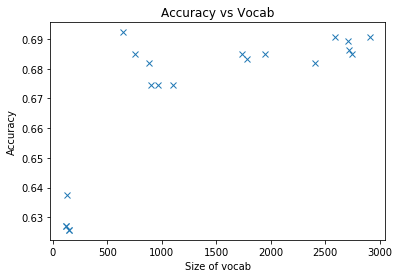

In [388]:
def P6():

    np.random.seed(0)
    
    # ---------- accuracy levels and number of non-zero coefficients given L1 vs L2 ---------------#

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data, train_labels)
    
    
    pipeline_LLM_L1 = Pipeline([  
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression(C=0.5, penalty='l1'))
        ])
    
    
    pipeline_LLM_L2 = Pipeline([  
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression(C=0.5, penalty='l2'))
        ])

    
    pipeline_LLM_L1.fit(train_data, train_labels)
    pipeline_LLM_L2.fit(train_data, train_labels)

    
    metric_LLM_L1 = metrics.accuracy_score(dev_labels, pipeline_LLM_L1.predict(dev_data))
    metric_LLM_L2 = metrics.accuracy_score(dev_labels, pipeline_LLM_L2.predict(dev_data))

    
    print("Accuracy score (L1) is %.2f " %metric_LLM_L1)
    print("Accuracy score (L2) is %.2f " %metric_LLM_L2)
    
    # ----- number of non-zero coefficients -----
        
    for i in ('l1','l2'):
        clf = LogisticRegression(C=0.5, penalty=i)
        clf.fit(X, train_labels)     
        print("Given the penalty of %s, the number of coefficients that are not zero are %d out of %d " 
              %(i, sum(np.any(clf.coef_!=0, axis=0)), np.size(clf.coef_)/4))

        
    # ------ Plotting given different C parameters -------- #
    
    # create random number of c parameters
    
    c_params = np.hstack((sorted(np.random.uniform(0.01,0.1,5)), 
                         sorted(np.random.uniform(0.1,1,5)),
                        sorted(np.random.uniform(1,10,5)),
                        sorted(np.random.uniform(10,100,5))))

  
    vocab = []
    accuracy = []

    for i in c_params:
        
        # for each C parameter, given penalty L1, identify non-zero vocabs
        
        clf_l1 = LogisticRegression(C=i, penalty='l1')
        clf_l1.fit(X, train_labels) 
        my_vocabs_p6 = np.array(vectorizer.get_feature_names())[np.any(clf_l1.coef_!=0, axis=0)]
        
        # vectorize data with set of non-zero vocabs
        vectorizer_L2 = CountVectorizer(vocabulary=my_vocabs_p6)
        X6 = vectorizer_L2.fit_transform(train_data, train_labels)
   
        # parameterize L2 model with new set of vocabs
        pipeline_LLM_P6 = Pipeline([  
            ('vectorizer', CountVectorizer(vocabulary=my_vocabs_p6)),
            ('classifier', LogisticRegression(C=i, penalty='l2', tol=0.01))
            ])

        pipeline_LLM_P6.fit(train_data, train_labels)

        # vocab size outcome
        vocab.append(len(my_vocabs_p6))
        
        # accuracy outcome
        metric_LLM_P6 = metrics.accuracy_score(dev_labels, pipeline_LLM_P6.predict(dev_data))
        accuracy.append(metric_LLM_P6)
        
        # print("Accuracy score given C of %.4f is %.3f, and vocab size of %d" %(i, metric_LLM_P6, len(my_vocabs_p6)))
        
    # Plot 
    plt.plot(vocab, accuracy, 'x')
    plt.title("Accuracy vs Vocab")
    plt.xlabel("Size of vocab")
    plt.ylabel("Accuracy")
    plt.show()
     
P6()


(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [491]:
def P7():
### STUDENT START ###

    vectorizer7 = TfidfVectorizer()
    X7 = vectorizer7.fit_transform(train_data, train_labels)
    X7_dev = vectorizer7.transform(dev_data, dev_labels)

    clf7 = LogisticRegression(C=100, penalty='l2')
    clf7.fit(X7, train_labels)

    # get predicted probabilities given dev data
    pred = clf7.predict_proba(X7_dev)

    # get max predicted probability given each subject
    pred_max = np.amax(pred, axis=1)

    # get predicted probability given each correct label
    pred_correct = pred[np.arange(pred.shape[0]),dev_labels]

    # calculate ratio R
    ratio = arg_max / pred_correct

    # identify index with the top 3 highest ratio
    j = ratio.argsort()[-3:][::-1]

    for i in j:
        print("Subject index %d" %(i+1))
        print("The ratio is %.2f" %ratio[i])
        print("The predicted label", categories[np.int(clf7.predict(X7_dev[i]))])
        print("The actual label is: ", categories[dev_labels[i]], "\n")
        print("The actual content is: \n\n", dev_data[i], "\n\n")

## STUDENT END ###
P7()

Subject index 216
The ratio is 929.36
The predicted label talk.religion.misc
The actual label is:  sci.space 

The actual content is: 

 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies,

How is TfidfVectorizer different from the CountVectorizer?

ANSWER:

(i) While CountVectorizer counts the frequency of the word occurences, TfidVectorizer further normalizes vocaularies and takes into account the frequency of the word occurence by by applying an "inverse document frequency" that lessens the importance of words such as "the" that frequently occurs but add less to the meaning of the content.

Reference: https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1


What kinds of mistakes is the model making? 

ANSWER: 

In the first two examples, the model predict the content to be of religious topic, when they are actually labeld "sci.space". Apparently, a key word "Mormon" that appears frequently in both examples must have weighted a lot in the model prediction, leadin to an inaccurate classification.

In the last example, 


Suggest a way to address one particular issue that you see.

ANSWER:

In the first two examples, I might replace the work "Book of Mormon" with something like "publishing", 

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.